## Hyperparameter optimization
Aim: To optimize the efficiency of the dropout layer in our model, by tuning the dropout rate parameter using Bayesian hyperparameter optimization with the `hyperopt` library. We can also tune other hyperparameters of the model such as the learning rate, number of neurons per layer, batch size, etc.
Parameters that define the models architechture are called hyperparameters.

General method:
- Define the range of possible values for the hyperparameter you want to optimize
- Define a method for sampling hyperparameter values
- Define a metric to evaluate the performance of the model, in our case we will use the validation loss
- Define a cross-validation method

Bayesian optimization uses a gaussian process to model the prior probablitly of model efficiency across the hyperparameter space, basically approximating how well the model will perform under a certain valued hyperparameter.

### Bayesian Optimization
Bayesian Optimization is reffered to as a Sequential model-based optimizer (SMBO) algorithm, algorithms that base they're next evaluation on the previous loss of some function $f$.

Bayesian optimization starts with an initial sampling set 





In [1]:
pip install hyperopt

Note: you may need to restart the kernel to use updated packages.


In [42]:
import tensorflow as tf
import numpy as np
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
from keras.layers import (Input, Conv2D, MaxPooling2D, BatchNormalization)
import os
from CNN import compile_fit_GenreModel, base_GenreModel
from CNN_final_test import GenreModel
import time

['pop', 'metal', 'disco', 'blues', 'reggae', 'classical', 'rock', 'hiphop', 'country', 'jazz']
Found 8990 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


The hyperparameter space defines all hyperparameters we are going to tune for the model and their accepted range of values. In this case we are going to focus on the following hyperparameters; learning rate, dropout rate, batch normalization, batch size, pooling type, 

In [12]:
space = {
    # Loguniform distribustion to find appropriate learning rate multiplier
    'lr_mult' : hp.loguniform('lr_mult', -0.5, 0.5),
    # Uniform distribustion to find appropriate dropout rate
    'dr' : hp.uniform('dr',0.0,0.5),
    # To find the best optimizer
    'optimizer' : hp.choice('optimizer', ['Adam', 'Nadam', 'RMSprop']),
    # l2 weight regularization multiplier
    'l2_mult' : hp.loguniform('l2_mult', -1.3, 1.3),
    
    'batch size' : hp.quniform('batch size', 10,50,2)
}

# want to add batch size, number of layers etc..

In [60]:
# prints graph of random values for each hyperparameter
# These values are not based on any specific model yet
print(hyperopt.pyll.stochastic.sample(space))

{'batch size': 24.0, 'dr': 0.13055706388952187, 'l2_mult': 1.7281490711384107, 'lr_mult': 0.9877860637446093, 'optimizer': 'Nadam'}


The fmin function is used to find the optimal value for a scalar valued function.

First we define a function for fmin to optimize. In our case we will judge the models performance based on the validation accuracy so we want out optimize function to return the negative value of the accuracy. The optimize function will build and train the model based on hyperspace parameters.

In [11]:
def run_a_trial():
    # function that runs a single optimization
    # first we check to see if theres any previous results saved
    
    try:
        trials = pickle.load(open('results.pkl', 'rb'))
        max_evals = len(trials.trials) + nb_evals
        print("Rerunning from {} trials to add another one.".format(len(trials.trials)))
    except:
        trials = Trials()
        
    best = fmin(optimize,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=1,
            )
    
    pickle.dump(trials, open("results.pkl", "wb"))
    
    return

In [8]:
RESULTS_DIR = 'Optimization_results'

def load_result(best_result_name):
    #Load json from a path (directory + filename).
    result_path = os.path.join(RESULTS_DIR, best_result_name)
    with open(result_path, 'r') as f:
        return json.JSONDecoder().decode(
            f.read()
            # default=json_util.default,
            # separators=(',', ': ')
        )


    
def load_best_hyperspace():
    results = [
        f for f in list(sorted(os.listdir(RESULTS_DIR))) if 'json' in f
    ]
    if len(results) == 0:
        return None

    best_result_name = results[-1]
    return load_result(best_result_name)["space"]


def get_best_model():
    best_space = load_best_hyperspace()
    return GenreModel(best_space)

In [10]:
# model checkpoint callback, saves model on the best value. Something to do with weights 

### Analysing results

After running the optimization process, we have a folder of results containing the hyperparameter space used for that specific trial and the corresponding validation accuracy. By selecting the results with the highes accuracy we can determine the optimal hyperparameter values for our model.

In [39]:
results_dir = 'Optimization_results'
# We want to oder the results from best to worst
results = sorted(os.listdir(results_dir))
results

['model_0.7799999713897705_0a937.txt.json',
 'model_0.8180000185966492_e73d3.txt.json',
 'model_0.8259999752044678_a87c0.txt.json',
 'model_0.8389999866485596_1cbaf.txt.json',
 'model_0.8389999866485596_c4400.txt.json',
 'model_0.8460000157356262_2fc17.txt.json',
 'model_0.859000027179718_70714.txt.json',
 'model_0.859000027179718_a6dc9.txt.json',
 'model_0.8659999966621399_a0ece.txt.json',
 'model_0.8669999837875366_8f74e.txt.json',
 'model_0.8769999742507935_9d32f.txt.json',
 'model_0.878000020980835_62c77.txt.json',
 'model_0.878000020980835_abf77.txt.json',
 'model_0.8790000081062317_a9bb4.txt.json',
 'model_0.8830000162124634_46864.txt.json',
 'model_0.8849999904632568_4924e.txt.json',
 'model_0.8870000243186951_a241e.txt.json',
 'model_0.8880000114440918_b459e.txt.json',
 'model_0.8899999856948853_3848e.txt.json',
 'model_0.8949999809265137_c9769.txt.json']

In [40]:
# Load results
import json
jsons = []
for file in results:
    file_path = f'{results_dir}/{file}'
    with open(file_path) as f:
        j = json.load(f)
    jsons.append(j)

print(list(jsons[0].keys()))
print(jsons[0]['space'])
print(jsons[0])

['best_accuracy', 'best_actual_loss', 'best_val_accuracy', 'best_val_loss', 'history', 'loss', 'space', 'status']
{'activation': 'elu', 'dropout': 0.4490296898170655, 'dropout_conv': None, 'kern_size': 4.0, 'l2_mult': 0.298050189888948, 'lr_mult': 1.6127089735380655, 'optimizer': 'Adam', 'pooling': 'avg', 'use_BN': True}
{'best_accuracy': 0.9403781890869141, 'best_actual_loss': 0.23308846354484558, 'best_val_accuracy': 0.7799999713897705, 'best_val_loss': 0.7613492012023926, 'history': {'accuracy': [0.3053392767906189, 0.45439377427101135, 0.5293659567832947, 0.5870967507362366, 0.6181312799453735, 0.6428253650665283, 0.6823136806488037, 0.7003337144851685, 0.7319243550300598, 0.7617352604866028, 0.7776418328285217, 0.7933259010314941, 0.8211345672607422, 0.8318130970001221, 0.8466073274612427, 0.8704115748405457, 0.8892102241516113, 0.8809788823127747, 0.8961067795753479, 0.9091212749481201, 0.9197998046875, 0.9304783344268799, 0.9285873174667358, 0.9234704971313477, 0.940378189086914

In [43]:
load_best_hyperspace()

{'activation': 'relu',
 'dropout': 0.42627829205868556,
 'dropout_conv': None,
 'kern_size': 3.0,
 'l2_mult': 0.40646031286098117,
 'lr_mult': 0.9210012408836846,
 'optimizer': 'Nadam',
 'pooling': 'max',
 'use_BN': False}

In [44]:
import matplotlib.pyplot as plt
import matplotlib

# Labels for scatterplot
params_names = [
    'lr_mult',
    'dropout',
    'optimizer',
    'l2_mult',
    'activation',
    'batch_size',
    'dropout_conv',
    'kern_size',
    'pooling'
]

params_values = [[mod["space"][p] for mod in jsons] for p in params_names]

best_accs = [model['best_val_accuracy'] for model in jsons]

# best_accs = []
# for mod in jsons:
#     best_accs.append(max(mod['val_ accuracy']))

KeyError: 'batch_size'

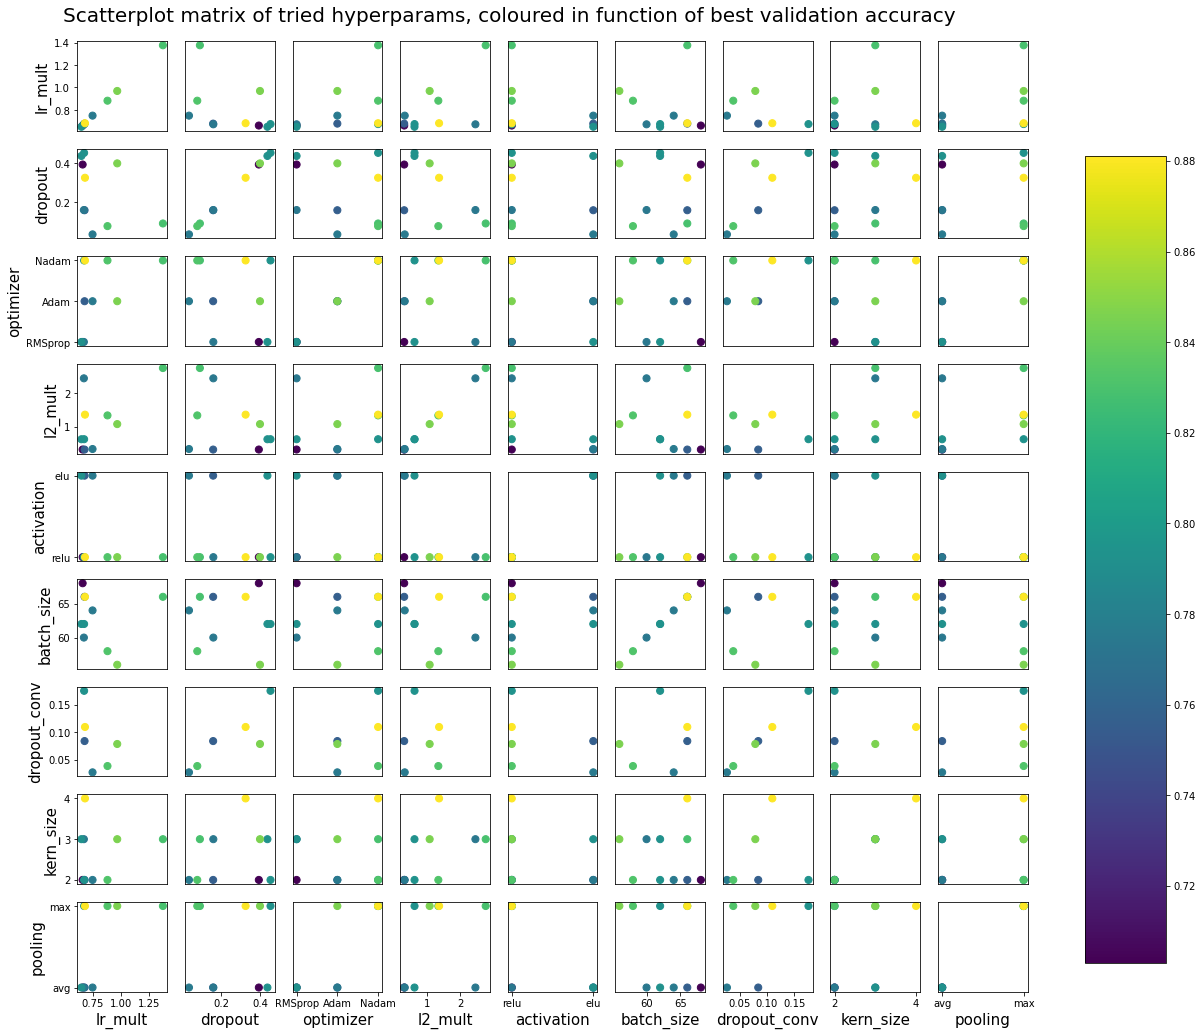

In [45]:
def scatter_plot_matrix(params_names, params_values, best_accs):
    
    num_params = len(params_values)
    best_accs = np.array(best_accs)
    norm = matplotlib.colors.Normalize(vmin=best_accs.min(), vmax=best_accs.max())
    
    fig, ax = plt.subplots(num_params, num_params, figsize=(16,16))
    
    for i in range(num_params):
        p1 = params_values[i]
        for j in range(num_params):
            p2 = params_values[j]
            
            axes = ax[i, j]
            
            s = axes.scatter(p2, p1, s=50, c=best_accs, cmap='viridis', norm=norm)     # s = dot size
            
            # Labels only on side subplots, for x and y:
            if j == 0:
                axes.set_ylabel(params_names[i], rotation=90, fontsize=15)
            else:
                axes.set_yticks([])
            
            if i == num_params - 1:
                axes.set_xlabel(params_names[j], rotation=0, fontsize=15)
            else:
                axes.set_xticks([])
                
            fig.subplots_adjust(right=0.95, top=0.95)     # size of individual boxes (width, height)
    cbar_ax = fig.add_axes([1, 0.15, 0.07, 0.7])           # colour bar (horz, vert, width, height)
    cb = fig.colorbar(s, cax=cbar_ax)
    
    plt.suptitle('Scatterplot matrix of tried hyperparams, coloured in function of best validation accuracy', fontsize=20)
    plt.show()
    
scatter_plot_matrix(params_names=params_names, params_values=params_values, best_accs=best_accs)


In our case 'loss' represents the validation accuracy 

avg best error: -0.8949999809265137


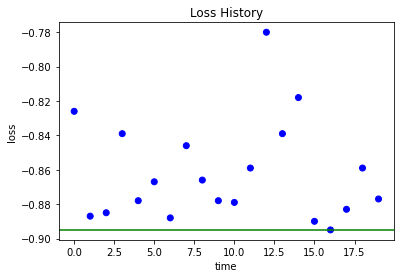

Showing Histogram of 20 jobs


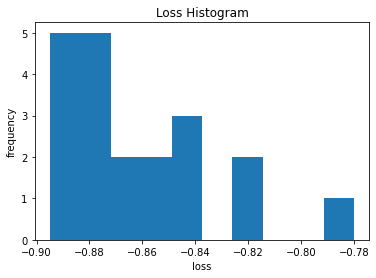

In [46]:
from hyperopt.plotting import main_plot_history, main_plot_histogram
import pickle

trials = pickle.load(open("results.pkl", "rb"))

print("In our case 'loss' represents the validation accuracy \n")
# This gives us a visualization of when the results were achieved with the green line representign
# the best result
main_plot_history(trials)
# This shows us the frequencies of accuracies achieved
main_plot_histogram(trials)